In [1]:
from numpy import array
from os import listdir
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from pywt import Wavelet
from math import floor, ceil
from numpy import concatenate, flipud, zeros, convolve
import random
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
"""# Tüm Fonksiyonlar"""

def create_eeg_matrix(directory, fix_length=False, length=None, row_channels=True):
    try:
        trials = listdir(directory)
    except:
        raise
    files=[]
    for trial in trials:
        files.append(f"{directory}/{trial}")


    data = pd.concat(map(pd.read_csv, files), ignore_index=True)
    data=data.dropna()
    data = data.iloc[1:]

    if not row_channels:
        data = data.T

    return array(data)

def time_windowing(eeg_matrix, window_size, sliding_window, start_type="begin", start_time=None, channels=None, verbose=True):
    window_size = int(window_size)
    sliding_window = int(sliding_window)

    recording_length = len(eeg_matrix[0])

    segmented_trial = []
    try:
        start = 0;

        while start + window_size <= recording_length:
            array1 = []
            for j in channels:
                X = eeg_matrix[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 1 sec
                array1.append(np.array(X, dtype=float))

            start = start + sliding_window
            segmented_trial.append(np.array(array1, dtype=float))
    except:
        raise
    segmented_trial = array(segmented_trial, dtype=float)
    #print(f"segment : {segmented_trial.shape}")

    return segmented_trial

def padding_symmetric(signal, size=8):
    padded_signal = concatenate([flipud(signal[:size]), signal, flipud(signal[-size:])])
    return padded_signal

def restore_signal(signal, reconstruction_filter, real_len):
    restored_signal = zeros(2 * len(signal) + 1)
    for i in range(len(signal)):
        restored_signal[i*2+1] = signal[i]
    restored_signal = convolve(restored_signal, reconstruction_filter)
    restored_len = len(restored_signal)
    exceed_len = (restored_len - real_len) / 2
    restored_signal = restored_signal[int(floor(exceed_len)):(restored_len - int(ceil(exceed_len)))]
    return restored_signal

def DWT(signal, level=3, mother_wavelet='db4'):
    if type(signal).__name__ != "ndarray" and type(signal) != list:
        raise TypeError(f"'signal' must be 'ndarray', received: '{type(signal).__name__}'")
    if type(signal) == list:
        signal = array(signal)
    if "float" not in signal.dtype.name and "int" not in signal.dtype.name:
        raise TypeError("All elements of 'signal' must be numbers")

    if type(level) != int:
        raise TypeError(f"'level' must be 'int', received: '{type(level).__name__}'")
    if level < 1:
        raise TypeError(f"'level' must be greater than 0, received: {level}")

    if mother_wavelet not in ['haar', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'dmey', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'shan', 'fbsp', 'cmor']:
        raise TypeError(f"Invalid 'mother_wavelet' must be 'haar', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'dmey', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'shan', 'fbsp', or 'cmor', received: '{mother_wavelet}'")

    original_len = len(signal)
    approx_coeff = []
    detail_coeff = []
    wavelet = Wavelet(mother_wavelet)
    low_filter = wavelet.dec_lo
    high_filter = wavelet.dec_hi
    filter_size = len(low_filter)
    try:
        for _ in range(level):
            padded_signal = padding_symmetric(signal, filter_size)
            low_pass_filtered_signal = convolve(padded_signal, low_filter)[filter_size:(2*filter_size)+len(signal)-1]
            low_pass_filtered_signal = low_pass_filtered_signal[1:len(low_pass_filtered_signal):2]
            high_pass_filtered_signal = convolve(padded_signal, high_filter)[filter_size:filter_size+len(signal)+filter_size-1]
            high_pass_filtered_signal = high_pass_filtered_signal[1:len(high_pass_filtered_signal):2]
            approx_coeff.append(low_pass_filtered_signal)
            detail_coeff.append(high_pass_filtered_signal)
            signal = low_pass_filtered_signal
    except:
        raise
    low_reconstruction_filter = wavelet.rec_lo
    high_reconstruction_filter = wavelet.rec_hi
    real_lengths = []
    for i in range(level-2,-1,-1):
        real_lengths.append(len(approx_coeff[i]))
    real_lengths.append(original_len)
    restored_approx_coeff = []
    for i in range(level):
        restored_signal = restore_signal(approx_coeff[i], low_reconstruction_filter, real_lengths[level-1-i])
        for j in range(i):
            restored_signal = restore_signal(restored_signal, low_reconstruction_filter, real_lengths[level-i+j])
        restored_approx_coeff.append(restored_signal)
    restored_detail_coeff = []
    for i in range(level):
        restored_signal = restore_signal(detail_coeff[i], high_reconstruction_filter, real_lengths[level-1-i])
        for j in range(i):
            restored_signal = restore_signal(restored_signal, high_reconstruction_filter, real_lengths[level-i+j])
        restored_detail_coeff.append(restored_signal)
    return restored_approx_coeff, restored_detail_coeff

In [3]:

"""# Parametrelerin Belirlenmesi"""

#------------CODE PARAMETERS------------
labels = [0, 1]
recording_length = 10000
window_size = 512
sliding_window=128

channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14,15,16,17,18]
chan=['Fp2','F8','T4','T6','O2','Fp1','F7','T3','T5','O1','F4','C4','P4','F3','C3','P3','Fz','Cz','Pz']

level = 4
mother_wavelet = 'db4'
detail_coefficients = {4: [1,2,3,4]}
approximation_coefficients = {4: [4]}
#detail_coefficients = {6: [1,2,3,4,5,6]}
#approximation_coefficients = {6: [6]}
#features = ["min", "rel_energy", "max", "mean", "std", "median", "energy", "skewness", "var","entropy"]


In [ ]:
final_data = {}
final_data[level] = {}

"""# Verilerin çekilmesi ve Özellik Çıkarımı

for i in labels:
    #print(f"--------- Label : {i}")
    data = create_eeg_matrix(f"C:/Users/umut_/Tensorflow/Schizophrenia_Detection/DATA/csv_data/{i}", True, recording_length, False)
    print("--------------------------------Data")
    print(data.shape)

    c=[]
    for a in range(len(data)):
        for b in range(len(data[a])):
            if data[a][b]==0. or data[a][b]==-0.:
                c.append(b)

    data = np.delete(data, c, 1)
    print(data.shape)
    windows = time_windowing(data, window_size, sliding_window, channels=channels, verbose=False)
    print("--------------------------------windows")
    print(windows.shape)

    dwt_data = []
    for trial in windows:
        trial_dwt = []
        for channel in trial:
            approx_coeffs, detail_coeffs = DWT(channel, level, mother_wavelet)
            trial_dwt.append({"A": approx_coeffs, "D": detail_coeffs})
        dwt_data.append(trial_dwt)
    print(f"dwt_data : {np.array(dwt_data).shape}")
    matrices = []
    sayac=1
    for trial in dwt_data:
        vector = []
        for k in range(len(channels)):
            channel = trial[k]
            signals = []
            for coeff in detail_coefficients[level]:
                signals.append(channel["D"][coeff-1])
            for coeff in approximation_coefficients[level]:
                signals.append(channel["A"][coeff-1])
            vector.extend(signals)
        matrices.append(vector)
        sayac+=1
    #print(f"matrices : {np.array(matrices)}")
    np.save(f"C:/Users/umut_/Tensorflow/Schizophrenia_Detection/DATA/csv_data/{i}", np.array(matrices), allow_pickle=True, fix_imports=True)
    final_data[level][i] = np.array(matrices)"""


In [4]:

"""# Veri ve Etiketlerin Ayarrlanması"""


final_data = {}
final_data[level] = []

data0=np.load('C:/Users/umut_/Tensorflow/Schizophrenia_Detection/DATA/csv_data/npler2/0.npy',allow_pickle=True)
data1=np.load('C:/Users/umut_/Tensorflow/Schizophrenia_Detection/DATA/csv_data/npler2/1.npy',allow_pickle=True)
final_data[level].append(data0) 
final_data[level].append(data1)

from sklearn.preprocessing import normalize
best_level = None
best_clf = None
best_params = None
best_metrics = None
max_performance = 0

print(f"**************************************************\n******************* Level : {level} *****************\n************************************")
print(f"-------------------final_data[level] : {len(final_data[level])}")
label=[]
data=[]
for i in labels:
    for j in range(len(final_data[level][i])):
        label.append(i)
        data.append(final_data[level][i][j])
        #print(f"data - {np.array(data).shape}")


optimization_indexes_per_class=[]
for i in range(len(data)):
    optimization_indexes_per_class.append(i)
random.shuffle(optimization_indexes_per_class)
data1=[]
label1=[]
for i in optimization_indexes_per_class:
    data1.append(data[i])
    label1.append(label[i])

#print(f"-------------------data1 : {np.array(data1, dtype=object).shape}")
#print(f"-------------------label1 : {np.array(label1).shape}")
data1=np.array(data1, dtype=object)
label1=np.array(label1, dtype=object)



**************************************************
******************* Level : 4 *****************
************************************
-------------------final_data[level] : 2


In [5]:
"""# Eğitim, Validasyon ve Test Verilerin Ayrılması ve Normalizasyon"""

x_train, x, y_train, y = train_test_split(data1, label1, test_size=0.10, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

print(f"x_train:{np.array(x_train).shape}")
print(f"x_val : {np.array(x_val).shape}")
print(f"x_test : {np.array(x_test).shape}")

print(f"y_train : {np.array(y_train).shape}")
print(f"y_val : {np.array(y_val).shape}")
print(f"y_test : {np.array(y_test).shape}")

unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

print(f"y_train : {np.array(y_train)}")

# Kategorik etiketleri hazırlama
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# 3 boyutlu veriler için her özelliği ayrı ayrı normalize etme
def normalize_3d(data):
    normalized_data = np.array([normalize(data[:, :, i]) for i in range(data.shape[2])])
    return np.transpose(normalized_data, (1, 2, 0))

# Verileri normalize etme
x_train_normalized = normalize_3d(x_train)
x_val_normalized = normalize_3d(x_val)
x_test_normalized = normalize_3d(x_test)

# Standartlaştırıcıyı hazırlama ve uygulama
scaler = StandardScaler()

# Verileri yeniden şekillendirme
x_train_flattened = x_train_normalized.reshape(-1, x_train_normalized.shape[-1])
x_val_flattened = x_val_normalized.reshape(-1, x_val_normalized.shape[-1])
x_test_flattened = x_test_normalized.reshape(-1, x_test_normalized.shape[-1])

# Standartlaştırma
x_train = scaler.fit_transform(x_train_flattened).reshape(x_train_normalized.shape)
x_val = scaler.transform(x_val_flattened).reshape(x_val_normalized.shape)
x_test = scaler.transform(x_test_flattened).reshape(x_test_normalized.shape)

# Şekilleri kontrol et
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")


print(f"y_train : {y_train.shape}")
print(f"y_val : {y_val.shape}")
print(f"y_test : {y_test.shape}")

input_shape=(x_train.shape[1],x_train.shape[2])
print(f"input_shape : {input_shape}")


x_train:(25804, 95, 512)
x_val : (1434, 95, 512)
x_test : (1434, 95, 512)
y_train : (25804,)
y_val : (1434,)
y_test : (1434,)
{0: 11728, 1: 14076}
{0: 639, 1: 795}
{0: 659, 1: 775}
y_train : [1 1 1 ... 0 0 0]
x_train shape: (25804, 95, 512)
x_val shape: (1434, 95, 512)
x_test shape: (1434, 95, 512)
y_train : (25804, 2)
y_val : (1434, 2)
y_test : (1434, 2)
input_shape : (95, 512)


In [13]:
# Verileri ve etiketleri kaydetme
np.save('x_train.npy', x_train)


print("Veriler başarıyla kaydedildi.")

NameError: name 'y_train_cat' is not defined

In [14]:
np.save('y_train.npy', y_train)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [6]:
"""# Sınıflandırma"""

batch_size = 256
num_classes = 2
epochs = 20

model=Sequential()
model.add(Conv1D(256, kernel_size=3,padding = 'same', input_shape=input_shape))
model.add(BatchNormalization(renorm=True))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(128,kernel_size=3,padding = 'same'))
model.add(BatchNormalization(renorm=True))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(64,kernel_size=3,padding = 'same'))
model.add(BatchNormalization(renorm=True))
model.add(Activation("relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy",
          optimizer='adam',
          metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=1,validation_data=(x_val, y_val))

print("Ortalama Doğrulama Kaybı : ", np.mean(history.history["val_loss"]))
print("Ortalama Doğrulama Başarımı : ", np.mean(history.history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 95, 256)           393472    
                                                                 
 batch_normalization (Batch  (None, 95, 256)           1792      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 95, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 47, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           9

In [7]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('C:/Users/umut_/Tensorflow/Schizophrenia_Detection/RESULT/cnn_model.h5')
np.save('C:/Users/umut_/Tensorflow/Schizophrenia_Detection/RESULT/cnn_model.npy', history.history)

"""# Sonuçlar ve Grafikler"""

directory = 'C:/Users/umut_/Tensorflow/Schizophrenia_Detection/RESULT/cnn_model.h5'
cnn_model = load_model(directory)
cnn_model.summary()

cnn_history = np.load('C:/Users/umut_/Tensorflow/Schizophrenia_Detection/RESULT/cnn_model.npy',allow_pickle='TRUE').item()
cnn_history.keys()

print("Training Accuracy: ", np.max(cnn_history['accuracy']))
print("Training Loss: ", np.min(cnn_history['loss']))
print("Validation Accuracy: ", np.max(cnn_history['val_accuracy']))
print("Validation Loss: ", np.min(cnn_history['val_loss']))

45/45 [==============================] - 3s 54ms/step - loss: 0.0514 - accuracy: 0.9881
Test loss: 0.051433268934488297
Test accuracy: 0.9881450533866882


C:\Users\umut_\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 95, 256)           393472    
                                                                 
 batch_normalization (Batch  (None, 95, 256)           1792      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 95, 256)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 47, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           9

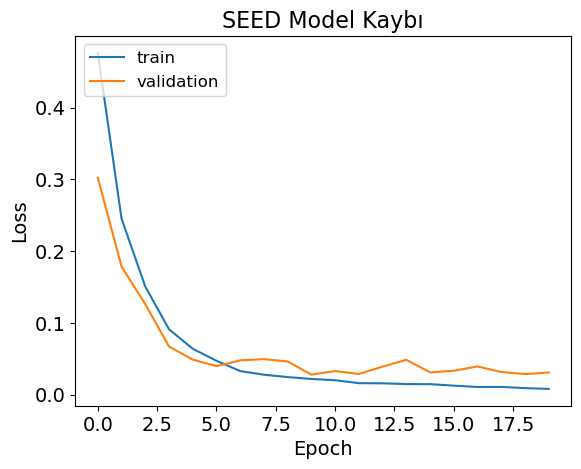

In [8]:

"""# summarize history for loss"""
plt.plot(cnn_history['loss'])
plt.plot(cnn_history['val_loss'])
plt.title('SEED Model Kaybı', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

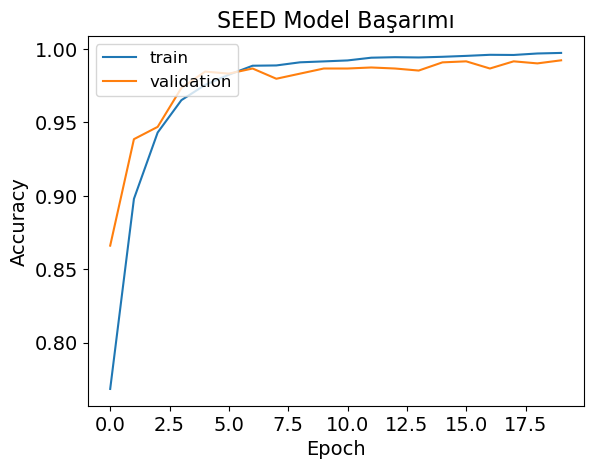

45/45 [==============================] - 2s 43ms/step


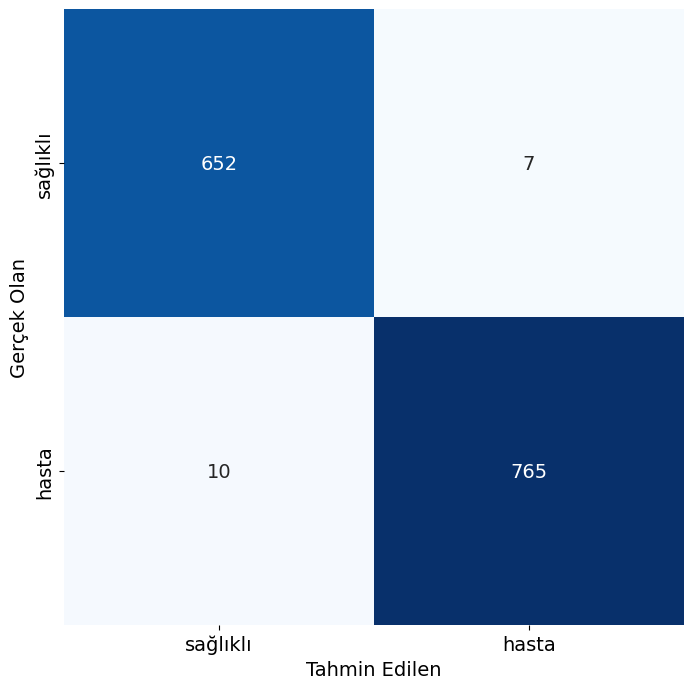

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       659
           1       0.99      0.99      0.99       775

    accuracy                           0.99      1434
   macro avg       0.99      0.99      0.99      1434
weighted avg       0.99      0.99      0.99      1434



In [12]:
"""# summarize history for Accuracy"""
plt.plot(cnn_history['accuracy'])
plt.plot(cnn_history['val_accuracy'])
plt.title('SEED Model Başarımı', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

class_names = ['sağlıklı','hasta']

y_pred = cnn_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(2) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(2) + 0.5, class_names, fontsize=14)
plt.xlabel("Tahmin Edilen", fontsize=14)
plt.ylabel("Gerçek Olan", fontsize=14)
plt.show()

print("Classification Report:\n----------------------\n", clr)